In [1]:
import os
import sys
import time
import datetime
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
np.set_printoptions(suppress=True)
import re
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import database_conncet as data_con
import data_processing as dp
import summary_statistics as ss
from data_io_utils import *

In [2]:
date = datetime.date.today().strftime('%m-%d')
file_path= os.path.join('/Users/yantingting/Seafile/风控/模型/10 印尼/测试202003调整年龄阈值/', date)
if not os.path.exists(file_path):
    os.mkdir(file_path)

# 转化率取数

In [3]:
query0 = '''
select  date(t1.createtime) as rc_time,
substring(t3.apply_time,1,4)::int - t2.year_age as age,
t3.device_approval,
count(distinct t3.id) as application ,
count(distinct case when t1.risklevel is not null and t1.risklevel <> '' then t3.id end) as RC ,
count(distinct case when t1.basicrulesnode = 'R' then t3.id end) as basicrulesnode,
count(distinct case when t1.modelnode = 'R' then t3.id end) as modelnode,
count(distinct case when t1.thirdpartrulenode = 'R' then t3.id end) as thirdpartrulenode,
count(distinct case when t1.thirdpartblacklist = 'R' then t3.id end) as thirdpartblacklist,
count(distinct case when t1.risklevel in ('N', 'P') then t3.id end) as RC_pass ,
count(distinct case when photo_result is not null and photo_result <> '' and t1.risklevel in ('N', 'P') then t3.id end) as photo,
count(distinct case when photo_result = 'ENABLE' and photo_result <> '' and t1.risklevel in ('N', 'P') then t3.id end) as photo_pass,
count(distinct case when bank_card_result is not null and bank_card_result <> '' and t1.risklevel in ('N', 'P') then t3.id end) as bank ,
count(distinct case when bank_card_result in('BIND', 'BINDING') and t1.risklevel in ('N', 'P') and bank_card_result <> '' then t3.id end) as bank_pass ,
count(distinct case when bank_card_result in('BIND', 'BINDING') and photo_result = 'ENABLE' and t1.risklevel in ('N', 'P') then t3.id end) as bankandphoto_pass,
count(distinct case when effective_date >= '2020-02-01' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then t3.id else null end)as fangkuan
from rt_risk_mongo_gocash_installmentriskcontrolresult t1 
left join (select orderno,substring(regexp_matches(datasources, '\d+')::varchar,2,4)::int as year_age
from rt_risk_mongo_gocash_riskreport
where ruleresultname = 'invalidAge') t2 
on t1.loanid = t2.orderno
left join rt_t_gocash_core_loan t3 
on t1.loanid = t3.id::varchar
where t1.createtime>='2020-03-05 17:00:00'
and t3.return_flag = 'false'
group by 1,2,3;
'''

In [4]:
df = data_con.database_gn(query0)
df['age'].fillna(0,inplace = True)
df['age_group'] = df['age'].astype(int).astype(int).apply(lambda x:"<18" if x<18 
                                    else '[18-21)' if x<21 
                                    else '[21-65]' if x<=65 
                                    else '>65')
save_data_to_pickle(df,file_path,'转化率.pkl')
df.shape

Successful connection


(925, 17)

# 转化率分析

In [3]:
df = load_data_from_pickle(file_path,'转化率.pkl')
df.shape
df.head()

(925, 17)

,rc_time,age,device_approval,application,rc,basicrulesnode,modelnode,thirdpartrulenode,thirdpartblacklist,rc_pass,photo,photo_pass,bank,bank_pass,bankandphoto_pass,fangkuan,age_group
0,2020-03-05,17,ANDROID,3,3,3,0,0,0,0,0,0,0,0,0,0,<18
1,2020-03-05,18,ANDROID,8,8,7,1,0,0,0,0,0,0,0,0,0,[18-21)
2,2020-03-05,18,IOS,1,1,1,0,0,0,0,0,0,0,0,0,0,[18-21)
3,2020-03-05,19,ANDROID,45,45,15,29,0,0,1,1,1,1,1,1,1,[18-21)
4,2020-03-05,19,IOS,4,4,1,2,0,0,1,1,1,1,1,1,1,[18-21)


In [16]:
frame1 = pd.pivot_table(df,index = ('device_approval','age_group'),
                        aggfunc={'application':'sum',\
		'rc':'sum','rc_pass':'sum',\
		'photo':'sum','photo_pass':'sum',\
		'bank':'sum','bank_pass':'sum',\
		'bankandphoto_pass':'sum',\
		'fangkuan':'sum',\
		'basicrulesnode':'sum',\
		'modelnode':'sum',\
		'thirdpartrulenode':'sum',\
		'thirdpartblacklist':'sum'}).reset_index()
frame1['风控机审通过率']=frame1.rc_pass/frame1.rc
frame1['内部规则通过率']=1-frame1.basicrulesnode/frame1.rc
frame1['模型通过率']= 1-frame1.modelnode/(frame1.rc-frame1.basicrulesnode)
frame1['三方规则通过率']=1-frame1.thirdpartrulenode/(frame1.rc-frame1.basicrulesnode-frame1.modelnode)
frame1['三方黑名单通过率']=1-frame1.thirdpartblacklist/(frame1.rc-frame1.basicrulesnode-frame1.modelnode-frame1.thirdpartrulenode)
frame1['照片审核通过率']=frame1.photo_pass/frame1.photo
frame1['银行卡审核通过率']=frame1.bank_pass/frame1.bank
frame1['人审通过率']=frame1.bankandphoto_pass/frame1.rc_pass
frame1['从申请到放款通过率']=frame1.fangkuan/frame1.application

# remain_list = [i for i in frame1.columns if i.find('通过率')>-1]
# frame1[remain_list].to_excel(os.path.join(file_path,'通过率.xlsx'))
frame1.to_excel(os.path.join(file_path,'通过率.xlsx'))
frame1




,device_approval,age_group,application,bank,bank_pass,bankandphoto_pass,basicrulesnode,fangkuan,modelnode,photo,photo_pass,rc,rc_pass,thirdpartblacklist,thirdpartrulenode,风控机审通过率,内部规则通过率,模型通过率,三方规则通过率,三方黑名单通过率,照片审核通过率,银行卡审核通过率,人审通过率,从申请到放款通过率
0,ANDROID,<18,36,0,0,0,36,0,0,0,0,36,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,ANDROID,>65,41,1,0,0,37,0,3,1,1,41,1,0,0,0.024390,0.097561,0.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2,ANDROID,[18-21),3257,214,196,194,1009,193,2001,214,211,3257,214,4,29,0.065705,0.690206,0.109875,0.882591,0.981651,0.985981,0.915888,0.906542,0.059257
3,ANDROID,[21-65],46930,8524,8082,7999,8049,7979,29240,8524,8436,46930,8524,207,911,0.181632,0.828489,0.247962,0.905508,0.976289,0.989676,0.948146,0.938409,0.170019
4,API,[18-21),48,4,4,4,15,4,29,4,4,48,4,0,0,0.083333,0.687500,0.121212,1.000000,1.000000,1.000000,1.000000,1.000000,0.083333
5,API,[21-65],1449,140,134,122,40,122,1257,140,128,1449,140,2,10,0.096618,0.972395,0.107878,0.934211,0.985915,0.914286,0.957143,0.871429,0.084196
6,IOS,<18,3,0,0,0,3,0,0,0,0,3,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
7,IOS,>65,1,0,0,0,1,0,0,0,0,1,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
8,IOS,[18-21),252,33,29,24,106,24,111,33,28,252,33,2,0,0.130952,0.579365,0.239726,1.000000,0.942857,0.848485,0.878788,0.727273,0.095238
9,IOS,[21-65],1807,638,606,494,351,494,794,638,517,1807,638,24,0,0.353071,0.805755,0.454670,1.000000,0.963746,0.810345,0.949843,0.774295,0.273381


In [7]:
all_a = frame1[frame1.index == '[18-21)']['application'][0]
all_1 = frame1[frame1.index == '[18-21)']['fangkuan'][0]
a0=[0]
a1=[1]
list1 = a1*all_1 + a0*(all_a - all_1)

all_a = frame1[frame1.index == '[21-65]']['application'][0]
all_1 = frame1[frame1.index == '[21-65]']['fangkuan'][0]
a0=[0]
a1=[1]
list2 = a1*all_1 + a0*(all_a - all_1)

t2, p2 = stats.ttest_ind(list1,list2)
print(p2)



7.274602936113415e-65


# 细节

## 取数

In [23]:
query_temp = '''
select  r.loanid,
        l.device_approval,
        l."grouping",
        l.request_period,
        l.approved_principal,
        m.ruleresultname, 
        m.ruleresult,
        substring(l.apply_time,1,4)::int - p.year_age as age,
        date(r.createtime) as rc_date,
		case when r.risklevel is not null and r.risklevel <> '' then 1 end as RC ,
		case when r.basicrulesnode = 'R' then 1 end as basicrulesnode,
	    case when r.modelnode = 'R' then 1 end as modelnode,
	    case when r.thirdpartrulenode = 'R' then 1 end as thirdpartrulenode,
	    case when r.thirdpartblacklist = 'R' then 1 end as thirdpartblacklist,
		case when r.risklevel in ('N', 'P') then 1 end as RC_pass ,
		case when photo_result is not null and photo_result <> '' and r.risklevel in ('N', 'P') then 1 end as photo,
	    case when photo_result = 'ENABLE' and photo_result <> '' and r.risklevel in ('N', 'P') then 1 end as photo_pass,
		case when bank_card_result is not null and bank_card_result <> '' and r.risklevel in ('N', 'P') then 1 end as bank ,
		case when bank_card_result in('BIND', 'BINDING') and r.risklevel in ('N', 'P') and bank_card_result <> '' then 1 end as bank_pass ,
		case when bank_card_result in('BIND', 'BINDING') and photo_result = 'ENABLE' and r.risklevel in ('N', 'P') then 1 end as bankandphoto_pass,
		case when r.risklevel in ('N', 'P') and human_trial = 'HUMAN_TRIAL' then 1 end as audit2,
		case when r.risklevel in ('N', 'P') and human_trial = 'HUMAN_TRIAL' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then 1 end as audit2pass,
		case when effective_date >= '2020-01-07' and loan_status not in ('DENIED', 'RESCIND', 'APPROVING', 'CREATED') then 1 else null end as fangkuan,
		case when r.existsloanwithcontacts = 'reject' then 1 end as existsloanwithcontacts ,
		case when r.installdangerapp = 'reject' then 1 end as installdangerapp ,
		case when r.callwithbadguys = 'reject' then 1 end as callwithbadguys ,
		case when r.blacklist = 'reject' then 1 end as blacklist ,
		case when r.invalidage = 'reject' then 1 end as invalidage ,
		case when r.deniedbyoccupation = 'reject' then 1 end as deniedbyoccupation ,
		case when r.installspecifyapp = 'reject' then 1 end as installspecifyapp ,
		case when r.deniedloanwith5fields = 'reject' then 1 end as deniedloanwith5fields ,
		case when r.duplicatecustomerwith5fields = 'reject' then 1 end as duplicatecustomerwith5fields ,
		case when r.existsloanwith5fields = 'reject' then 1 end as existsloanwith5fields ,
		case when r.bankantifraud = 'reject' then 1 end as bankantifraud ,
		case when r.worklocationrestrict = 'reject' then 1 end as worklocationrestrict ,
		case when r.basicrulesnode in ('N','P') then 1 end as  basicrulesnode_pass,
		case when r.basicrulesnode='R' then 1 end as  basicrulesnode_reject,
		case when r.newusermodelresultv5 = 'reject' then 1 end as newusermodelresultv5 ,
		case when r.denyiziinquiriesbytypetotal = 'reject' then 1 end as denyiziinquiriesbytypetotal ,
		case when r.denyiziphoneage = 'reject' then 1 end as denyiziphoneage ,
		case when r.thirdpartrulenode in ('N','P') then 1 end as  thirdpartrulenode_pass,
		case when r.thirdpartrulenode='R' then 1 end as  thirdpartrulenode_reject,
		case when r.ruhiablacklist = 'reject' then 1 end as ruhiablacklist ,
		case when r.xhprcblacklist = 'reject' then 1 end as xhprcblacklist ,
		case when r.xhprcgreylist = 'reject' then 1 end as xhprcgreylist,
		case when r.thirdpartblacklist in ('N','P') then 1 end as  thirdpartblacklist_pass,
		case when r.thirdpartblacklist='R' then 1 end as  thirdpartblacklist_reject
	from  rt_risk_mongo_gocash_installmentriskcontrolresult r 
	left join 
	(select orderno,riskno,substring(regexp_matches(datasources, '\d+')::varchar,2,4)::int as year_age
     from rt_risk_mongo_gocash_riskreport
     where ruleresultname = 'invalidAge') p on p.riskno = r.riskno
left join  
(select orderno, riskno,ruleresultname, ruleresult
from rt_risk_mongo_gocash_riskreport
where ruleresultname in ('newUserModelScoreV6','newUserModelScoreV5')) m 
on r.riskno = m.riskno
left join rt_t_gocash_core_loan l on r.loanid = l.id::varchar
where r.createtime>='2020-03-05 17:00:00' and l.return_flag = 'false';
'''

In [24]:
df_temp = data_con.database_gn(query_temp)
df_temp['age'].fillna(0,inplace = True)
df_temp['age_group'] = df_temp['age'].astype(int).astype(int).apply(lambda x:"<18" if x<18 
                                    else '[18-21)' if x<21 
                                    else '[21-65]' if x<=65 
                                    else '>65')
save_data_to_pickle(df_temp,file_path,'temp.pkl')
df_temp.shape

Successful connection


(54448, 48)

## 模型分

(1888, 45)

(33421, 45)

589.8183262711865
600.5787977618862


Text(0.5, 1.0, '18-20 vs. 21-65 application_v5')

Text(0.5, 0, 'Model Score')

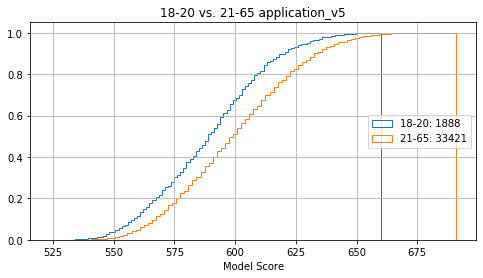

p = 2.675790122222677e-72


(170, 45)

(6787, 45)

630.7764705882353
634.8108147929865


Text(0.5, 1.0, '18-20 vs. 21-65 Loan_v5')

Text(0.5, 0, 'Model Score')

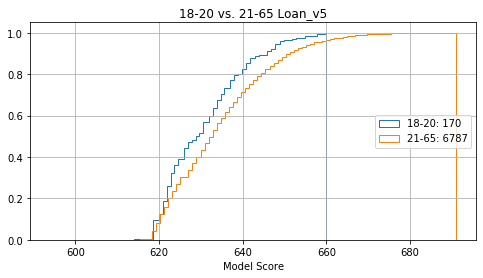

p = 1.9097823277983438e-05


In [17]:
df_temp = load_data_from_pickle(file_path,'temp.pkl')
df_temp = df_temp[df_temp['ruleresultname'] =='newUserModelScoreV5']
df_temp['ruleresult'] = df_temp['ruleresult'].astype(float)
df_10 = df_temp[df_temp['age_group']=='[18-21)']
df_10.shape
df_11 = df_temp[df_temp['age_group']=='[21-65]']
df_11.shape
print(df_10.ruleresult.mean())
print(df_11.ruleresult.mean())

fig, ax = plt.subplots(figsize=(8, 4))
n_bins = 100
# plot the cumulative histogram
n, bins, patches = ax.hist(df_10.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='18-20: %s'%df_10.shape[0])
n, bins, patches = ax.hist(df_11.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='21-65: %s'%df_11.shape[0])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('18-20 vs. 21-65 application_v5')
ax.set_xlabel('Model Score')
plt.savefig(os.path.join(file_path, '18-20 vs. 21-65 application_v5' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
# T TEST
t2, p2 = stats.ttest_ind(df_10.ruleresult,df_11.ruleresult)
# print("t = " + str(t2))
print("p = " + str(p2))


#放款
df_temp = df_temp[df_temp['ruleresultname'] =='newUserModelScoreV5']
df_temp = df_temp[df_temp['fangkuan']==1]
df_temp['ruleresult'] = df_temp['ruleresult'].astype(float)
df_10 = df_temp[df_temp['age_group']=='[18-21)']
df_10.shape
df_11 = df_temp[df_temp['age_group']=='[21-65]']
df_11.shape
print(df_10.ruleresult.mean())
print(df_11.ruleresult.mean())

fig, ax = plt.subplots(figsize=(8, 4))
n_bins = 100
# plot the cumulative histogram
n, bins, patches = ax.hist(df_10.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='18-20: %s'%df_10.shape[0])
n, bins, patches = ax.hist(df_11.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='21-65: %s'%df_11.shape[0])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('18-20 vs. 21-65 Loan_v5')
ax.set_xlabel('Model Score')
plt.savefig(os.path.join(file_path, '18-20 vs. 21-65 Loan_v5' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
# T TEST
t2, p2 = stats.ttest_ind(df_10.ruleresult,df_11.ruleresult)
# print("t = " + str(t2))
print("p = " + str(p2))

(401, 45)

(6967, 45)

597.1670822942643
607.6469068465624


Text(0.5, 1.0, '18-20 vs. 21-65 application_v6')

Text(0.5, 0, 'Model Score')

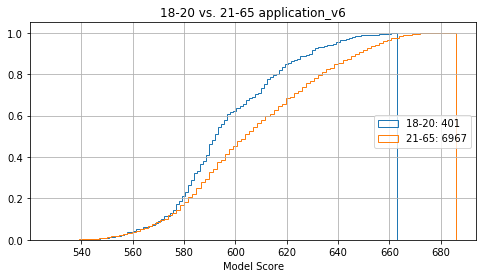

p = 4.714381186327053e-13


(27, 45)

(1331, 45)

641.6296296296297
648.0864012021037


Text(0.5, 1.0, '18-20 vs. 21-65 Loan_v6')

Text(0.5, 0, 'Model Score')

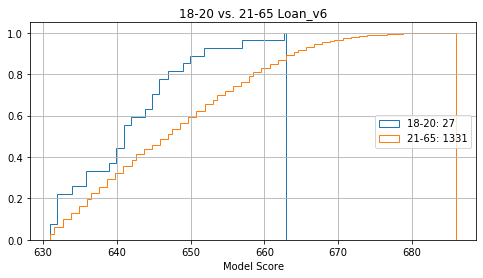

p = 0.003969080988769727


In [18]:
df_temp = load_data_from_pickle(file_path,'temp.pkl')
df_temp = df_temp[df_temp['ruleresultname'] =='newUserModelScoreV6']
df_temp['ruleresult'] = df_temp['ruleresult'].astype(float)
df_10 = df_temp[df_temp['age_group']=='[18-21)']
df_10.shape
df_11 = df_temp[df_temp['age_group']=='[21-65]']
df_11.shape
print(df_10.ruleresult.mean())
print(df_11.ruleresult.mean())

fig, ax = plt.subplots(figsize=(8, 4))
n_bins = 100

# plot the cumulative histogram
n, bins, patches = ax.hist(df_10.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='18-20: %s'%df_10.shape[0])
n, bins, patches = ax.hist(df_11.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='21-65: %s'%df_11.shape[0])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('18-20 vs. 21-65 application_v6')
ax.set_xlabel('Model Score')
plt.savefig(os.path.join(file_path, '18-20 vs. 21-65 application_v6' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

# T TEST
t2, p2 = stats.ttest_ind(df_10.ruleresult,df_11.ruleresult)
# print("t = " + str(t2))
print("p = " + str(p2))


# 放款
df_temp = df_temp[df_temp['ruleresultname'] =='newUserModelScoreV6']
df_temp = df_temp[df_temp['fangkuan']==1]
df_temp['ruleresult'] = df_temp['ruleresult'].astype(float)
df_10 = df_temp[df_temp['age_group']=='[18-21)']
df_10.shape
df_11 = df_temp[df_temp['age_group']=='[21-65]']
df_11.shape
print(df_10.ruleresult.mean())
print(df_11.ruleresult.mean())

fig, ax = plt.subplots(figsize=(8, 4))
n_bins = 100
# plot the cumulative histogram
n, bins, patches = ax.hist(df_10.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='18-20: %s'%df_10.shape[0])
n, bins, patches = ax.hist(df_11.ruleresult, n_bins, density=True, histtype='step',
                           cumulative=True, label='21-65: %s'%df_11.shape[0])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('18-20 vs. 21-65 Loan_v6')
ax.set_xlabel('Model Score')
plt.savefig(os.path.join(file_path, '18-20 vs. 21-65 Loan_v6' +'.png'), format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
# T TEST
t2, p2 = stats.ttest_ind(df_10.ruleresult,df_11.ruleresult)
# print("t = " + str(t2))
print("p = " + str(p2))



## 规则

In [9]:
the_df = load_data_from_pickle(file_path,'temp.pkl')
tmp_conversion_df = the_df.groupby(['device_approval','age_group']).\
		agg({'rc':'sum','rc_pass':'sum',\
		'photo':'sum','photo_pass':'sum',\
		'bank':'sum','bank_pass':'sum',\
		'bankandphoto_pass':'sum',\
		'fangkuan':'sum',\
		'basicrulesnode':'sum',\
		'modelnode':'sum',\
		'thirdpartrulenode':'sum',\
		'thirdpartblacklist':'sum',\
		'existsloanwithcontacts':'sum',\
		'installdangerapp':'sum',\
		'blacklist':'sum',\
		'invalidage':'sum',\
		'deniedbyoccupation':'sum',\
		'installspecifyapp':'sum',\
		'deniedloanwith5fields':'sum',\
		'duplicatecustomerwith5fields':'sum',\
		'existsloanwith5fields':'sum',\
		'bankantifraud':'sum',\
		'worklocationrestrict':'sum',\
		'newusermodelresultv5':'sum',\
		'denyiziinquiriesbytypetotal':'sum',\
		'denyiziphoneage':'sum',\
		'ruhiablacklist':'sum',\
		'xhprcblacklist':'sum',\
		'xhprcgreylist':'sum',\
		'basicrulesnode_pass':'sum',\
		'thirdpartrulenode_pass':'sum'}).reset_index()
tmp_conversion_df['风控机审通过率']=tmp_conversion_df.rc_pass/tmp_conversion_df.rc
tmp_conversion_df['照片审核通过率']=tmp_conversion_df.photo_pass/tmp_conversion_df.photo
tmp_conversion_df['银行卡审核通过率']=tmp_conversion_df.bank_pass/tmp_conversion_df.bank
tmp_conversion_df['人申通过率']=tmp_conversion_df.bankandphoto_pass/tmp_conversion_df.rc_pass
tmp_conversion_df['内部规则通过率']=1-tmp_conversion_df.basicrulesnode/tmp_conversion_df.rc
tmp_conversion_df['模型通过率']= 1-tmp_conversion_df.modelnode/(tmp_conversion_df.rc-tmp_conversion_df.basicrulesnode)
tmp_conversion_df['三方规则通过率']=1-tmp_conversion_df.thirdpartrulenode/(tmp_conversion_df.rc-tmp_conversion_df.basicrulesnode-tmp_conversion_df.modelnode)
tmp_conversion_df['三方黑名单通过率']=1-tmp_conversion_df.thirdpartblacklist/(tmp_conversion_df.rc-tmp_conversion_df.basicrulesnode-tmp_conversion_df.modelnode-tmp_conversion_df.thirdpartrulenode)
tmp_conversion_df['existsloanwithcontacts_reject']=tmp_conversion_df.existsloanwithcontacts/tmp_conversion_df.rc
tmp_conversion_df['installdangerapp_reject']=tmp_conversion_df.installdangerapp/tmp_conversion_df.rc
tmp_conversion_df['blacklist_reject']=tmp_conversion_df.blacklist/tmp_conversion_df.rc
tmp_conversion_df['invalidage_reject']=tmp_conversion_df.invalidage/tmp_conversion_df.rc
tmp_conversion_df['deniedbyoccupation _reject']=tmp_conversion_df.deniedbyoccupation/tmp_conversion_df.rc
tmp_conversion_df['installspecifyapp_reject']=tmp_conversion_df.installspecifyapp/tmp_conversion_df.rc
tmp_conversion_df['deniedloanwith5fields_reject']=tmp_conversion_df.deniedloanwith5fields/tmp_conversion_df.rc
tmp_conversion_df['duplicatecustomerwith5fields_reject']=tmp_conversion_df.duplicatecustomerwith5fields/tmp_conversion_df.rc
tmp_conversion_df['existsloanwith5fields_reject']=tmp_conversion_df.existsloanwith5fields/tmp_conversion_df.rc
tmp_conversion_df['bankantifraud_reject']=tmp_conversion_df.bankantifraud/tmp_conversion_df.rc
tmp_conversion_df['worklocationrestrict_reject']=tmp_conversion_df.worklocationrestrict/tmp_conversion_df.rc
tmp_conversion_df['newusermodelresultv5_reject']=tmp_conversion_df.newusermodelresultv5/tmp_conversion_df.basicrulesnode_pass
tmp_conversion_df['denyiziinquiriesbytypetotal_reject']=tmp_conversion_df.denyiziinquiriesbytypetotal/(tmp_conversion_df.basicrulesnode_pass-tmp_conversion_df.newusermodelresultv5)
tmp_conversion_df['denyiziphoneage_reject']=tmp_conversion_df.denyiziphoneage/(tmp_conversion_df.basicrulesnode_pass-tmp_conversion_df.newusermodelresultv5)
tmp_conversion_df['ruhiablacklist_reject']=tmp_conversion_df.ruhiablacklist/tmp_conversion_df.thirdpartrulenode_pass
tmp_conversion_df['xhprcblacklist_reject']=tmp_conversion_df.xhprcblacklist/tmp_conversion_df.thirdpartrulenode_pass
tmp_conversion_df['xhprcgreylist_reject']=tmp_conversion_df.xhprcgreylist/tmp_conversion_df.thirdpartrulenode_pass
tmp_conversion_df.to_excel(os.path.join(file_path,'规则详情.xlsx'))
tmp_conversion_df	


,device_approval,age_group,rc,rc_pass,photo,photo_pass,bank,bank_pass,bankandphoto_pass,fangkuan,basicrulesnode,modelnode,thirdpartrulenode,thirdpartblacklist,existsloanwithcontacts,installdangerapp,blacklist,invalidage,deniedbyoccupation,installspecifyapp,deniedloanwith5fields,duplicatecustomerwith5fields,existsloanwith5fields,bankantifraud,worklocationrestrict,newusermodelresultv5,denyiziinquiriesbytypetotal,denyiziphoneage,ruhiablacklist,xhprcblacklist,xhprcgreylist,basicrulesnode_pass,thirdpartrulenode_pass,风控机审通过率,照片审核通过率,银行卡审核通过率,人申通过率,内部规则通过率,模型通过率,三方规则通过率,三方黑名单通过率,existsloanwithcontacts_reject,installdangerapp_reject,blacklist_reject,invalidage_reject,deniedbyoccupation _reject,installspecifyapp_reject,deniedloanwith5fields_reject,duplicatecustomerwith5fields_reject,existsloanwith5fields_reject,bankantifraud_reject,worklocationrestrict_reject,newusermodelresultv5_reject,denyiziinquiriesbytypetotal_reject,denyiziphoneage_reject,ruhiablacklist_reject,xhprcblacklist_reject,xhprcgreylist_reject
0,ANDROID,<18,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0,3.0,0.0,36.0,8.0,1.0,4.0,2.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,0.083333,0.000000,1.000000,0.222222,0.027778,0.111111,0.055556,0.027778,0.000000,0.222222,NaN,NaN,NaN,NaN,NaN,NaN
1,ANDROID,>65,41,1.0,1.0,1.0,1.0,0.0,0.0,0.0,37.0,3.0,0.0,0.0,0,0.0,0.0,35.0,8.0,0.0,3.0,2.0,1.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.024390,1.000000,0.000000,0.000000,0.097561,0.250000,1.000000,1.000000,0.0,0.000000,0.000000,0.853659,0.195122,0.000000,0.073171,0.048780,0.024390,0.000000,0.195122,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ANDROID,[18-21),3268,214.0,214.0,211.0,214.0,196.0,194.0,193.0,1012.0,2009.0,29.0,4.0,0,70.0,0.0,138.0,706.0,16.0,123.0,83.0,62.0,11.0,708.0,1643.0,28.0,1.0,3.0,1.0,0.0,2256.0,218.0,0.065483,0.985981,0.915888,0.906542,0.690330,0.109486,0.882591,0.981651,0.0,0.021420,0.000000,0.042228,0.216034,0.004896,0.037638,0.025398,0.018972,0.003366,0.216646,0.728280,0.045677,0.001631,0.013761,0.004587,0.000000
3,ANDROID,[21-65],47045,8542.0,8542.0,8452.0,8542.0,8096.0,8011.0,7996.0,8069.0,29313.0,914.0,208.0,0,1048.0,563.0,13.0,3957.0,251.0,1571.0,1109.0,838.0,106.0,4013.0,23970.0,875.0,45.0,134.0,103.0,9.0,38976.0,8749.0,0.181571,0.989464,0.947787,0.937837,0.828483,0.247922,0.905412,0.976226,0.0,0.022277,0.011967,0.000276,0.084111,0.005335,0.033394,0.023573,0.017813,0.002253,0.085301,0.614994,0.058310,0.002999,0.015316,0.011773,0.001029
4,API,[18-21),48,4.0,4.0,4.0,4.0,4.0,4.0,4.0,15.0,29.0,0.0,0.0,0,1.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,33.0,4.0,0.083333,1.000000,1.000000,1.000000,0.687500,0.121212,1.000000,1.000000,0.0,0.020833,0.000000,0.312500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.878788,0.000000,0.000000,0.000000,0.000000,0.000000
5,API,[21-65],1452,141.0,141.0,129.0,141.0,135.0,123.0,123.0,40.0,1259.0,10.0,2.0,0,16.0,1.0,5.0,0.0,3.0,5.0,0.0,1.0,1.0,8.0,1258.0,9.0,1.0,1.0,2.0,0.0,1412.0,143.0,0.097107,0.914894,0.957447,0.872340,0.972452,0.108357,0.934641,0.986014,0.0,0.011019,0.000689,0.003444,0.000000,0.002066,0.003444,0.000000,0.000689,0.000689,0.005510,0.890935,0.058442,0.006494,0.006993,0.013986,0.000000
6,IOS,<18,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
7,IOS,>65,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,IOS,[18-21),252,33.0,33.0,28.0,33.0,29.0,24.0,24.0,106.0,111.0,0.0,2.0,0,0.0,0.0,4.0,92.0,0.0,10.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,146.0,35.0,0.130952,0.8484

## 期限和额度

In [28]:
??pd.pivot_table

In [33]:
df_1 = load_data_from_pickle(file_path,'temp.pkl')
df_11 = df_1[df_1['fangkuan']==1]
pd.pivot_table(df_11, index = 'age_group',columns='request_period',aggfunc={'fangkuan':'sum'},fill_value = 0).reset_index()
pd.pivot_table(df_11, index = 'age_group',columns='approved_principal',aggfunc={'fangkuan':'sum'},fill_value = 0).reset_index()

age_group fangkuan                  
request_period                  8    15    22    29
0                [18-21)        3    81    90    50
1                [21-65]      116  2706  3514  2333

age_group fangkuan                                      \
approved_principal           500000.0 600000.0 700000.0 800000.0 900000.0   
0                    [18-21)       28        1       20        3        5   
1                    [21-65]      503       10      318        7      236   

                                                                      \
approved_principal 1000000.0 1100000.0 1200000.0 1300000.0 1400000.0   
0                         25        19        15         4         0   
1                        626       481       944       110        40   

                                        
approved_principal 1500000.0 1700000.0  
0                        101         3  
1                       5196       198